# Using Machine Learning Tools 2021, Assignment 3

## Sign Language Image Classification using Deep Learning

In [1]:
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports

import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)

mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import pandas as pd
import tensorflow as tf
from tensorflow import keras



### Pre-Processing

In [2]:
df_train = pd.read_csv('sign_mnist_train.csv',  header=0)
df_train.describe()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,...,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000
mean,12.325369,145.419377,148.500273,151.247714,153.546531,156.210891,158.411255,160.472154,162.339683,163.954799,...,141.104863,147.495611,153.325806,159.125332,161.969259,162.736696,162.906137,161.966454,161.137898,159.824731
std,7.374907,41.358555,39.942152,39.056286,38.595247,37.111165,36.125579,35.016392,33.661998,32.651607,...,63.751194,65.512894,64.427412,63.708507,63.738316,63.444008,63.509210,63.298721,63.610415,64.396846
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,121.000000,126.000000,130.000000,133.000000,137.000000,140.000000,142.000000,144.000000,146.000000,...,92.000000,96.000000,103.000000,112.000000,120.000000,125.000000,128.000000,128.000000,128.000000,125.500000
50%,13.000000,150.000000,153.000000,156.000000,158.000000,160.000000,162.000000,164.000000,165.000000,166.000000,...,144.000000,162.000000,172.000000,180.000000,183.000000,184.000000,184.000000,182.000000,182.000000,182.000000
75%,19.000000,174.000000,176.000000,178.000000,179.000000,181.000000,182.000000,183.000000,184.000000,185.000000,...,196.000000,202.000000,205.000000,207.000000,208.000000,207.000000,207.000000,206.000000,204.000000,204.000000
max,200.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000


Here we can see the max label is 200 which is not correct as per the datatset description. So we need to remove every rows that dosent have the correct labels. I will kepp only labels from 0 to 25. The pixels values for 784 features are in the range on 0 to 255, hence i am not doing any data cleaning. I will normalize the values by dividing it by 255. It will convert the range of pixels from 0 to 1 which will make computation much more faster. I will also reshape the features from (-1, 784) to (-1, 28, 28), as it will be the input shape to the layers in the subsequent models.

In [3]:
# removing outliers
df_train = df_train[df_train.label <26] 

# splitting into features and labels
df_train_values = df_train.values
X_train = df_train_values[:,1:]
y_train = df_train_values[:,0]

# normalizing
X_train=X_train/255

# reshaping
X_train = X_train.reshape(-1,28,28)
X_train.shape

(27454, 28, 28)

Let's see how the data distrubition is across the labels. By looking at the plot we can also see if we have removed the outliers correctly to.

<AxesSubplot:>

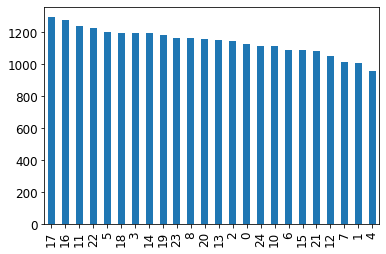

In [4]:
df_train['label'].value_counts().plot.bar()

Lets see if there are any labels missing in the dataset

In [5]:
labels_list = df_train['label'].unique()

# print missing labels
for i in range(26):
    if(i not in labels_list):
        print(i)


9
25


Lets see how the test set looks

In [6]:
from sklearn.model_selection import train_test_split

df_test = pd.read_csv('sign_mnist_test.csv',  header=0)
df_test.describe()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,7172.000000,7172.000000,7172.000000,7172.000000,7172.000000,7172.000000,7172.000000,7172.000000,7172.000000,7172.000000,...,7172.000000,7172.000000,7172.000000,7172.000000,7172.000000,7172.000000,7172.000000,7172.000000,7172.000000,7172.000000
mean,11.247351,147.532627,150.445761,153.324317,155.663413,158.169688,160.790853,162.282766,163.649191,165.589515,...,138.546570,145.539598,150.744980,155.638873,158.893196,159.648494,158.162019,157.672755,156.664250,154.776771
std,7.446712,43.593144,41.867838,40.442728,39.354776,37.749637,36.090916,36.212636,35.885378,33.721876,...,64.501665,65.132370,65.760539,65.565147,65.200300,65.499368,66.493576,66.009690,67.202939,68.285148
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,122.000000,126.000000,130.000000,134.000000,137.000000,141.000000,144.000000,145.000000,147.000000,...,90.000000,95.000000,99.000000,105.000000,113.000000,113.750000,113.000000,115.000000,111.000000,106.750000
50%,11.000000,154.000000,157.000000,159.000000,161.000000,163.000000,165.000000,166.000000,168.000000,169.000000,...,137.000000,155.000000,168.000000,177.000000,181.000000,182.000000,181.000000,180.000000,180.000000,179.000000
75%,18.000000,178.000000,179.000000,181.000000,182.000000,184.000000,185.000000,186.000000,187.000000,187.000000,...,195.000000,200.000000,204.250000,207.000000,207.000000,208.000000,207.000000,205.000000,206.000000,204.000000
max,24.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000


<AxesSubplot:>

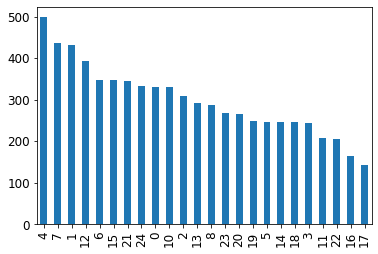

In [7]:
df_test['label'].value_counts().plot.bar()

It looks like the test set dosenot have any outliers problems. so we will define test and val using the same preprocessing we did for train

In [8]:

df_test_values = df_test.values

# split test.csv 50:50 to get test and val split with startify to ensure unifrom distrbution of labels
test_set, val_set = train_test_split(df_test_values, test_size=.50, random_state=42, stratify=df_test_values[:,0])

# splitting into features and labels
X_val = val_set[:,1:]
y_val = val_set[:,0]

# normalizing and reshaping
X_val=X_val/255
X_val = X_val.reshape(X_val.shape[0],28,28)

# splitting into features and labels
X_test = test_set[:,1:]
y_test = test_set[:,0]

# normalizing and reshaping
X_test=X_test/255
X_test = X_test.reshape(X_test.shape[0],28,28)

df_test.describe()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,7172.000000,7172.000000,7172.000000,7172.000000,7172.000000,7172.000000,7172.000000,7172.000000,7172.000000,7172.000000,...,7172.000000,7172.000000,7172.000000,7172.000000,7172.000000,7172.000000,7172.000000,7172.000000,7172.000000,7172.000000
mean,11.247351,147.532627,150.445761,153.324317,155.663413,158.169688,160.790853,162.282766,163.649191,165.589515,...,138.546570,145.539598,150.744980,155.638873,158.893196,159.648494,158.162019,157.672755,156.664250,154.776771
std,7.446712,43.593144,41.867838,40.442728,39.354776,37.749637,36.090916,36.212636,35.885378,33.721876,...,64.501665,65.132370,65.760539,65.565147,65.200300,65.499368,66.493576,66.009690,67.202939,68.285148
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,122.000000,126.000000,130.000000,134.000000,137.000000,141.000000,144.000000,145.000000,147.000000,...,90.000000,95.000000,99.000000,105.000000,113.000000,113.750000,113.000000,115.000000,111.000000,106.750000
50%,11.000000,154.000000,157.000000,159.000000,161.000000,163.000000,165.000000,166.000000,168.000000,169.000000,...,137.000000,155.000000,168.000000,177.000000,181.000000,182.000000,181.000000,180.000000,180.000000,179.000000
75%,18.000000,178.000000,179.000000,181.000000,182.000000,184.000000,185.000000,186.000000,187.000000,187.000000,...,195.000000,200.000000,204.250000,207.000000,207.000000,208.000000,207.000000,205.000000,206.000000,204.000000
max,24.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000


Lets display an image and its label

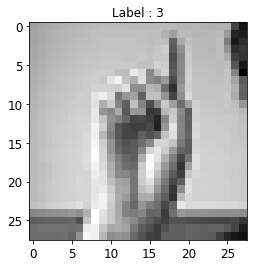

In [9]:
first_image = np.array(X_train[8])
pixels = first_image.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.title("Label : {}".format(y_train[8]))
plt.show()

## DCN

Lets define a few functions that we will using frequently

In [81]:
def plot_history(history):
    # Plot the results (shifting validation curves appropriately)
    plt.figure(figsize=(8,5))
    n = len(history.history['accuracy'])
    plt.plot(np.arange(0,n),history.history['accuracy'], color='orange')
    plt.plot(np.arange(0,n),history.history['loss'],'b')
    plt.plot(np.arange(0,n)+0.5,history.history['val_accuracy'],'r')  # offset both validation curves
    plt.plot(np.arange(0,n)+0.5,history.history['val_loss'],'g')
    plt.legend(['Train Acc','Train Loss','Val Acc','Val Loss'])
    plt.grid(True)
    plt.gca().set_ylim(0, 1) # set the vertical range to [0-1] 
    plt.xlabel("No of epochs")
    plt.ylabel("Metrics")  
    plt.show() 

In [80]:
def plot_history_multiple(history, axes, value):
    # Plot the results (shifting validation curves appropriately)
    # axes.figure(figsize=(8,5))
    n = len(history.history['accuracy'])
    axes.plot(np.arange(0,n),history.history['accuracy'], color='orange')
    axes.plot(np.arange(0,n),history.history['loss'],'b')
    axes.plot(np.arange(0,n)+0.5,history.history['val_accuracy'],'r')  # offset both validation curves
    axes.plot(np.arange(0,n)+0.5,history.history['val_loss'],'g')
    axes.legend(['Train Acc','Train Loss','Val Acc','Val Loss'])
    axes.grid(True)
    axes.set_ylim(0, 1) # set the vertical range to [0-1] 
    axes.set_xlabel("No of epochs")
    axes.set_ylabel("Metrics") 
    axes.title.set_text('Max val acc : {:.3f}, Test acc : {:.3f} \n  Unit sizes : {}, Optimizer : {}'.format(value[0], value[1], value[2], value[3]))

In this section lets create a baseline model for densely connected network (DCN)

In [11]:
def create_baseline_dcn(hiddensizes, activation, optimizer, learningrate):
    """"
    Parameters 
        hiddensizes : list of units for layers which are the dimensionality of the output space of the partiuclar layer
        activation : Activation fuctions like relu or softmax to be used by the layer
        optimizer : Optimizers like Adam or SGD
        learninrate : learning rate
    Return
        return a sequential model
    """
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape = [28 , 28]))    # input should match our resized data shape
    # add Dense layers
    for n in hiddensizes:
        model.add(keras.layers.Dense(n, activation = activation))
    model.add(keras.layers.Dense(25, activation = "softmax"))   # 26 classes but we dont have 25 hence no of units in output is 25
    
    # complie the model using sparse_categorical_crossentropy as loss (as it is not in one hot encoding format) and metrics as accuracy
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer(lr=learningrate), metrics=["accuracy"])
    return model

Lets define the hyperparamter values for our baseline DCN

In [12]:
hiddensizes = [100]  
# Define the activation function to be used by hidden layers
actfn = "relu"
# Optimiser and learning rate
optimizer = keras.optimizers.SGD
learningrate = 0.01
# Set number of epochs
n_epochs = 20

In [13]:
model = create_baseline_dcn(hiddensizes, actfn, optimizer, learningrate)

# early stopping helps us save the modle best val_accuarcy and stop when the model is not improving after ceratin epochs which is defined by patinence
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True) 
# fit the model with tearly stopping and validation
history = model.fit(X_train, y_train, epochs=n_epochs, callbacks = [early_stopping], validation_data=(X_val, y_val), verbose=1)

# get the max val accuarcy
max_val_acc = np.max(history.history['val_accuracy'])
max_val_acc

Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Epoch 1/20


2022-08-19 19:29:09.913658: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-19 19:29:09.913760: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/aaron/.virtualenvs/ai/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
2022-08-19 19:29:10.067537: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


 13/858 [..............................] - ETA: 3s - loss: 3.2720 - accuracy: 0.0433  

2022-08-19 19:29:10.193583: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


851/858 [============================>.] - ETA: 0s - loss: 2.7452 - accuracy: 0.2477

2022-08-19 19:29:13.722519: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


858/858 [==============================] - 4s 4ms/step - loss: 2.7414 - accuracy: 0.2493 - val_loss: 2.3911 - val_accuracy: 0.3703
Epoch 2/20
858/858 [==============================] - 3s 4ms/step - loss: 1.9453 - accuracy: 0.4979 - val_loss: 1.8450 - val_accuracy: 0.4598
Epoch 3/20
858/858 [==============================] - 3s 4ms/step - loss: 1.5098 - accuracy: 0.6052 - val_loss: 1.5528 - val_accuracy: 0.5273
Epoch 4/20
858/858 [==============================] - 3s 4ms/step - loss: 1.2585 - accuracy: 0.6613 - val_loss: 1.4044 - val_accuracy: 0.5597
Epoch 5/20
858/858 [==============================] - 3s 4ms/step - loss: 1.0872 - accuracy: 0.7067 - val_loss: 1.2810 - val_accuracy: 0.6152
Epoch 6/20
858/858 [==============================] - 3s 4ms/step - loss: 0.9605 - accuracy: 0.7418 - val_loss: 1.2473 - val_accuracy: 0.6160
Epoch 7/20
858/858 [==============================] - 3s 4ms/step - loss: 0.8609 - accuracy: 0.7683 - val_loss: 1.1727 - val_accuracy: 0.6484
Epoch 8/20
858/85

0.7052426338195801

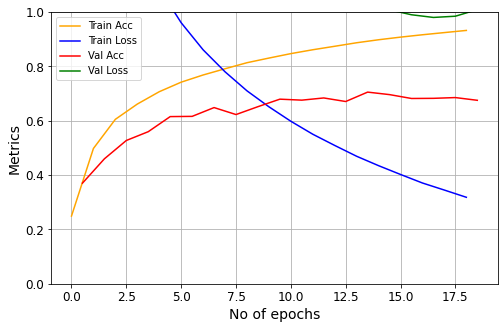

In [14]:
plot_history(history)

Lets do hyperparmeter tuning on DCN

In [15]:
# same as the baseline
def create_model(hiddensizes, activation, optimizer, learningrate):
    """"
    Parameters 
        hiddensizes : list of units for layers which are the dimensionality of the output space of the partiuclar layer
        activation : Activation fuctions like relu or softmax to be used by the layer
        optimizer : Optimizers like Adam or SGD
        learninrate : learning rate
    Return
        return a sequential model
    """
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape = [28 , 28]))    # always have same sized inputs
    for n in hiddensizes:
        model.add(keras.layers.Dense(n, activation = activation))
    model.add(keras.layers.Dense(25, activation = "softmax"))   # 26 classes
    
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer(lr=learningrate), metrics=["accuracy"])
    return model



In [16]:
def do_all(hiddensizes, actfn, optimizer, learningrate, n_epochs):
    """"
    Parameters 
        hiddensizes : list of units for layers which are the dimensionality of the output space of the partiuclar layer
        actfn : Activation fuctions like relu or softmax to be used by the layer
        optimizer : Optimizers like Adam or SGD
        learninrate : learning rate
        n_epochs : no of epochs
    Return
        maximmun validation acc, test accurcay, model history, sequential model
    """

    # create model
    model_dcn = create_model(hiddensizes, actfn, optimizer, learningrate)
    
    # fit the model
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True) 
    history = model_dcn.fit(X_train, y_train, epochs=n_epochs, callbacks = [early_stopping], validation_data=(X_val, y_val), verbose=0)
    
    # val and test accuracy
    max_val_acc = np.max(history.history['val_accuracy'])
    testres = model_dcn.evaluate(X_test, y_test, verbose=0)
    return max_val_acc, testres[1], history, model_dcn

I choose 3 differnet seetings for value of units. Just two layers with 300 and 100 units might not be enough. If i add more layers and more units, the the model has more parameters to learn features. But if i have toomany layers it could also lead to over fitting. 

The 3 learning rates i choose are some standard learning rates which is not so big that there is rapid chnages and not too small that in the few 20 epochs there is no reasonable learning that can be achievied. It will take more epochs if the lr is too small to reach the 96% accuracy

Two optimizer i choose are Adam and SGD because they will converge fast. Eventhough Adam is computationally costlier thans SGD, it is one of the best optimizers for NN.

/Users/aaron/.virtualenvs/ai/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


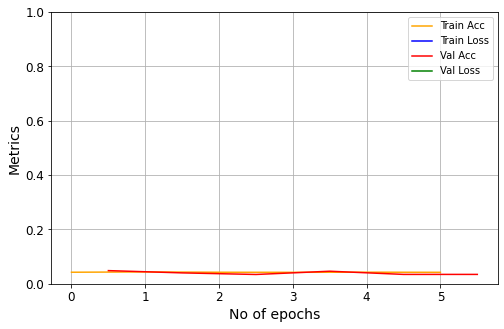

[0.04852202907204628, 0.04852202907204628, [500, 300, 100], 0.1, <class 'keras.optimizers.optimizer_v2.adam.Adam'>]


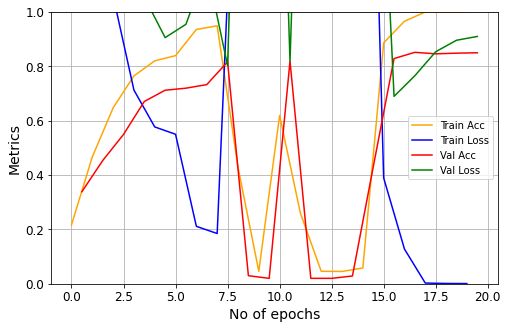

[0.851645290851593, 0.8471834659576416, [500, 300, 100], 0.1, <class 'keras.optimizers.optimizer_v2.gradient_descent.SGD'>]


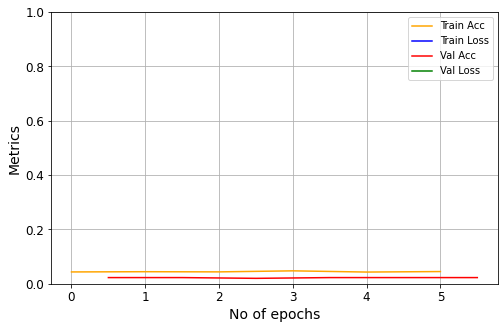

[0.02286670356988907, 0.02286670356988907, [500, 300, 100], 0.01, <class 'keras.optimizers.optimizer_v2.adam.Adam'>]


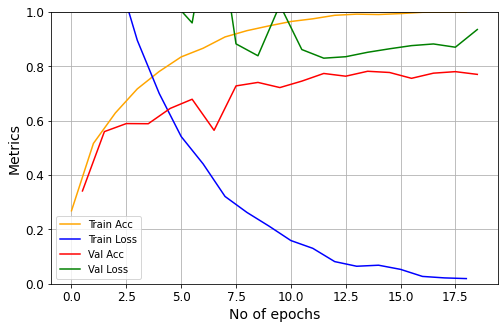

[0.7819297313690186, 0.7875069975852966, [500, 300, 100], 0.01, <class 'keras.optimizers.optimizer_v2.gradient_descent.SGD'>]


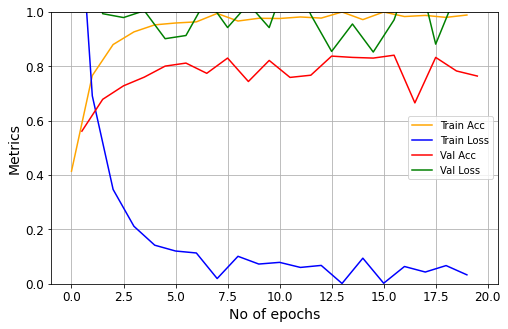

[0.841048538684845, 0.7626882195472717, [500, 300, 100], 0.001, <class 'keras.optimizers.optimizer_v2.adam.Adam'>]


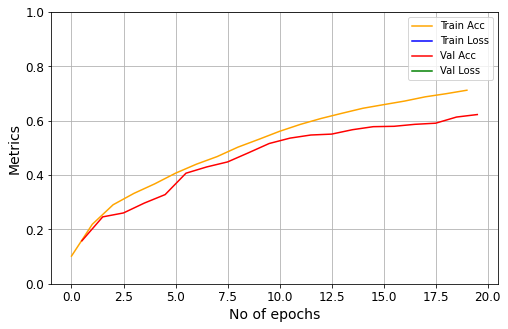

[0.6226993799209595, 0.6224205493927002, [500, 300, 100], 0.001, <class 'keras.optimizers.optimizer_v2.gradient_descent.SGD'>]


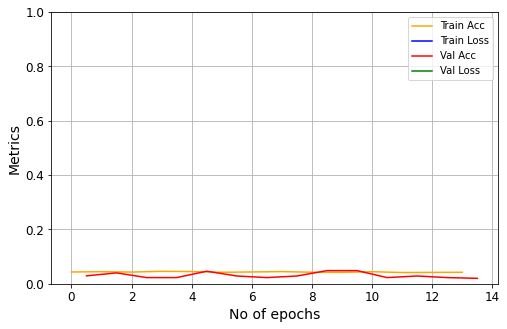

[0.04852202907204628, 0.04852202907204628, [500, 300, 200, 100], 0.1, <class 'keras.optimizers.optimizer_v2.adam.Adam'>]


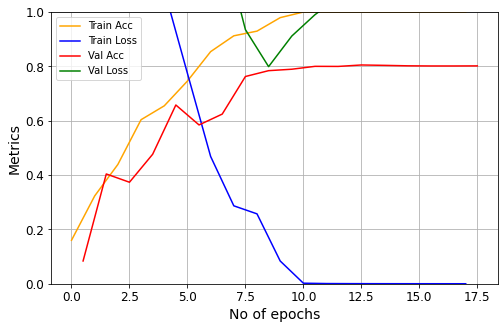

[0.8050752878189087, 0.7936419248580933, [500, 300, 200, 100], 0.1, <class 'keras.optimizers.optimizer_v2.gradient_descent.SGD'>]


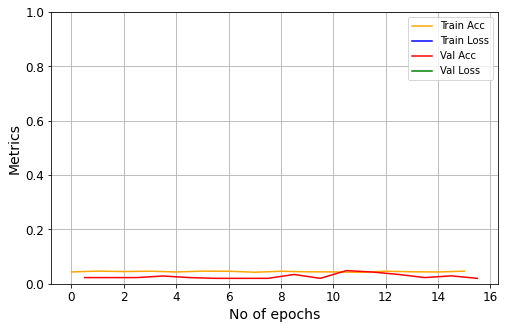

[0.04852202907204628, 0.048243168741464615, [500, 300, 200, 100], 0.01, <class 'keras.optimizers.optimizer_v2.adam.Adam'>]


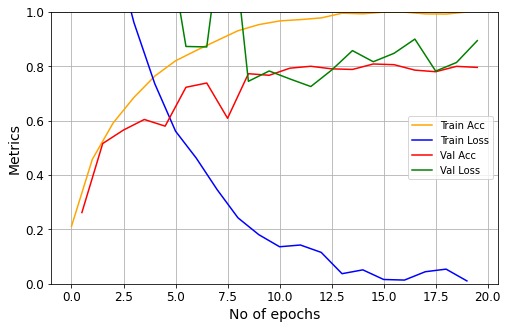

[0.8087005019187927, 0.7939208149909973, [500, 300, 200, 100], 0.01, <class 'keras.optimizers.optimizer_v2.gradient_descent.SGD'>]


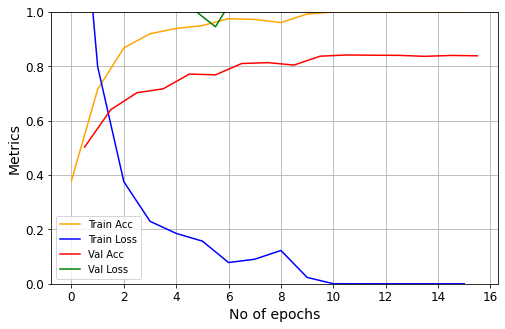

[0.8418850898742676, 0.8360289931297302, [500, 300, 200, 100], 0.001, <class 'keras.optimizers.optimizer_v2.adam.Adam'>]


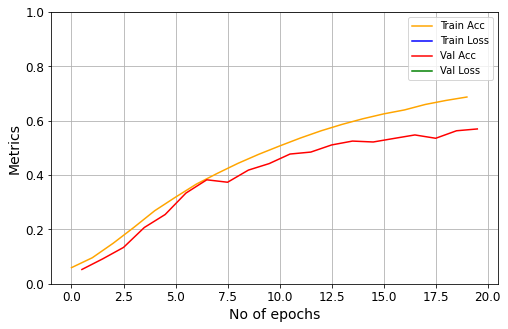

[0.5697155594825745, 0.5861684083938599, [500, 300, 200, 100], 0.001, <class 'keras.optimizers.optimizer_v2.gradient_descent.SGD'>]


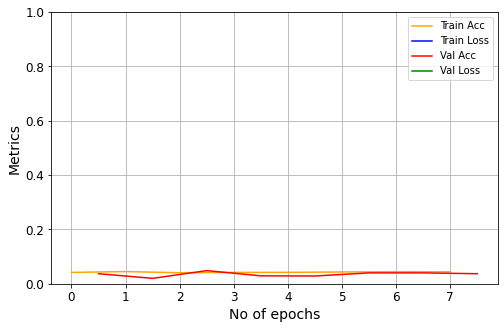

[0.04852202907204628, 0.04852202907204628, [300, 100], 0.1, <class 'keras.optimizers.optimizer_v2.adam.Adam'>]


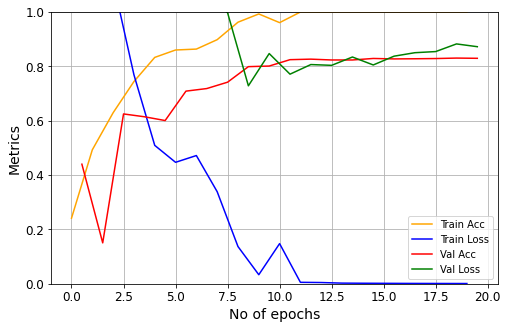

[0.8304517865180969, 0.8329614996910095, [300, 100], 0.1, <class 'keras.optimizers.optimizer_v2.gradient_descent.SGD'>]


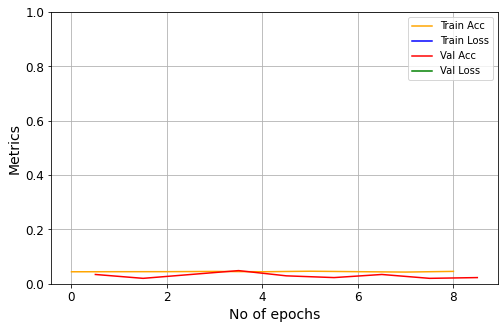

[0.04852202907204628, 0.04852202907204628, [300, 100], 0.01, <class 'keras.optimizers.optimizer_v2.adam.Adam'>]


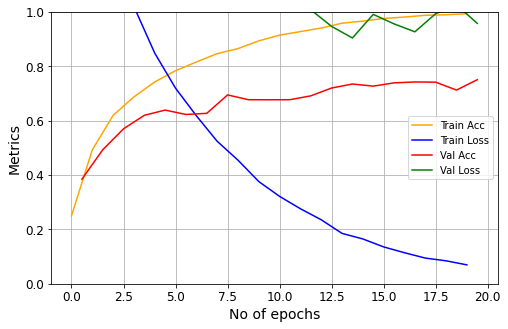

[0.750976026058197, 0.754601240158081, [300, 100], 0.01, <class 'keras.optimizers.optimizer_v2.gradient_descent.SGD'>]


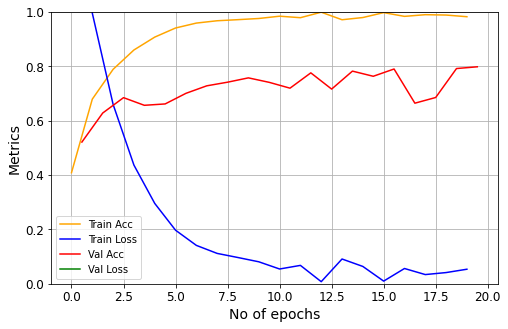

[0.798382580280304, 0.796709418296814, [300, 100], 0.001, <class 'keras.optimizers.optimizer_v2.adam.Adam'>]


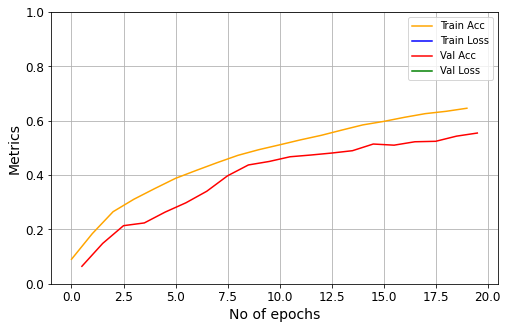

[0.554656982421875, 0.5610708594322205, [300, 100], 0.001, <class 'keras.optimizers.optimizer_v2.gradient_descent.SGD'>]


In [17]:
hiddensizes_list = [[500, 300, 100], [500, 300,200, 100], [300, 100] ]

lr_list = [0.1, 0.01, 0.001]
optimizer_list = [keras.optimizers.Adam, keras.optimizers.SGD] 
actfn = "relu"
n_epochs=20

history_list_dcn=[]
values=[]
# running it on cpu
with tf.device('/device:CPU:0'):
    # looping through different hyper parameter to try out all combinations
    for hiddensizes in hiddensizes_list:
        for learningrate in lr_list:
            for optimizer in optimizer_list:
                val_acc, test_acc, history, model_dcn = do_all(hiddensizes, actfn, optimizer, learningrate, n_epochs)
                plot_history(history)
                print([val_acc, test_acc, hiddensizes, learningrate, optimizer])
                # append it to a list to and display it later
                values.append([val_acc, test_acc, hiddensizes, learningrate, optimizer])
                history_list_dcn.append(history)

In [18]:
# display results in a table
df_dcn = pd.DataFrame(values, columns = ['Val_acc', 'Test_acc', 'hiddensizes', 'learningrate', 'optimizer'])
# sort based on val_accuracy
df_dcn = df_dcn.sort_values(by=['Val_acc'], ascending=False)
df_dcn

,Val_acc,Test_acc,hiddensizes,learningrate,optimizer
1,0.851645,0.847183,"[500, 300, 100]",0.100,<class 'keras.optimizers.optimizer_v2.gradient...
10,0.841885,0.836029,"[500, 300, 200, 100]",0.001,<class 'keras.optimizers.optimizer_v2.adam.Adam'>
4,0.841049,0.762688,"[500, 300, 100]",0.001,<class 'keras.optimizers.optimizer_v2.adam.Adam'>
13,0.830452,0.832961,"[300, 100]",0.100,<class 'keras.optimizers.optimizer_v2.gradient...
9,0.808701,0.793921,"[500, 300, 200, 100]",0.010,<class 'keras.optimizers.optimizer_v2.gradient...
7,0.805075,0.793642,"[500, 300, 200, 100]",0.100,<class 'keras.optimizers.optimizer_v2.gradient...
16,0.798383,0.796709,"[300, 100]",0.001,<class 'keras.optimizers.optimizer_v2.adam.Adam'>
3,0.781930,0.787507,"[500, 300, 100]",0.010,<class 'keras.optimizers.optimizer_v2.gradient...
15,0.750976,0.754601,"[300, 100]",0.010,<class 'keras.optimizers.optimizer_v2.gradient...
5,0.622699,0.622421,"[500, 300, 100]",0.001,<class 'keras.optimizers.optimizer_v2.gradient...


Now let train our model using the hyperparmter settings based on the best val_accuracy from the above table.

In [19]:
# no of units for different layers
hiddensizes = [500, 300, 100]  

# Define the activation function to be used by hidden layers
activation = "relu"

# Optimiser and learning rate
optimizer = keras.optimizers.SGD
learningrate = 0.1

n_epochs = 20

# create the model
model_dcn = create_model(hiddensizes, activation, optimizer, learningrate)
model_dcn.summary()


Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_19 (Flatten)        (None, 784)               0         
                                                                 
 dense_74 (Dense)            (None, 500)               392500    
                                                                 
 dense_75 (Dense)            (None, 300)               150300    
                                                                 
 dense_76 (Dense)            (None, 100)               30100     
                                                                 
 dense_77 (Dense)            (None, 25)                2525      
                                                                 
Total params: 575,425
Trainable params: 575,425
Non-trainable params: 0
_________________________________________________________________


/Users/aaron/.virtualenvs/ai/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
 39/858 [>.............................] - ETA: 3s - loss: 3.2056 - accuracy: 0.0369

2022-08-19 19:36:41.888530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


857/858 [============================>.] - ETA: 0s - loss: 2.5801 - accuracy: 0.2133

2022-08-19 19:36:45.365728: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


858/858 [==============================] - 4s 4ms/step - loss: 2.5795 - accuracy: 0.2135 - val_loss: 1.9840 - val_accuracy: 0.3399
Epoch 2/20
858/858 [==============================] - 4s 4ms/step - loss: 1.7406 - accuracy: 0.4369 - val_loss: 1.5110 - val_accuracy: 0.4640
Epoch 3/20
858/858 [==============================] - 3s 4ms/step - loss: 1.0571 - accuracy: 0.6489 - val_loss: 1.1326 - val_accuracy: 0.5987
Epoch 4/20
858/858 [==============================] - 4s 4ms/step - loss: 0.8422 - accuracy: 0.7269 - val_loss: 1.0392 - val_accuracy: 0.6849
Epoch 5/20
858/858 [==============================] - 4s 4ms/step - loss: 0.5048 - accuracy: 0.8386 - val_loss: 1.1938 - val_accuracy: 0.6985
Epoch 6/20
858/858 [==============================] - 4s 4ms/step - loss: 0.3096 - accuracy: 0.9048 - val_loss: 0.6875 - val_accuracy: 0.7864
Epoch 7/20
858/858 [==============================] - 3s 4ms/step - loss: 0.1806 - accuracy: 0.9516 - val_loss: 0.8097 - val_accuracy: 0.7817
Epoch 8/20
858/85

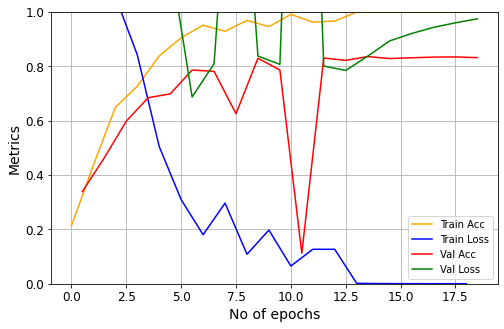

In [20]:
# train the model with early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True) 
# training on cpu cause of issues related m1 gpu supports

with tf.device('/device:CPU:0'):
    history = model_dcn.fit(X_train, y_train, epochs=n_epochs, validation_data=(X_val, y_val), callbacks=[early_stopping])
    plot_history(history)

The model seems to gradually get a good val accuracy by the last epoch epoch. But the loss is very fluctuating. It goes low then goes up. So this DCN architecture is not a good model. But let us see how it performs on test set.

In [21]:
# Display best accuracy on validation set
max_val_acc = np.max(history.history['val_accuracy'])
print(f'Best validation accuracy = {max_val_acc:.3f}')   # NB: .3f displays 3 decimal places

# Evaluate on testset
testres = model_dcn.evaluate(X_test, y_test, verbose=0)
print(f'Accuracy on test set = {testres[1]:.3f}')

Best validation accuracy = 0.836


2022-08-19 19:39:32.907610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Accuracy on test set = 0.829


### CNN


Now let's build a baseline CNN with just one layer and default params.

In [22]:
# Build a CNN
def build_baseline_cnn(hiddensizes, actfn, optimizer, learningrate):
    """"
    Parameters 
        hiddensizes : list of units for layers which are the dimensionality of the output space of the partiuclar layer
        actfn : Activation fuctions like relu or softmax to be used by the layer
        optimizer : Optimizers like Adam or SGD
        learninrate : learning rate
    Return
        return a sequential model
    """
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(filters=hiddensizes[0], kernel_size=3, strides=1, activation=actfn, padding="same", 
                                input_shape=[28, 28, 1]))    # input layer goes into this 2D convolution
    model.add(keras.layers.MaxPooling2D(pool_size=2))          # Pool (downsize)

    for n in hiddensizes[1:]:
        model.add(keras.layers.Conv2D(filters=n, kernel_size=3, strides=1, padding="same"))  # 2D Conv
        model.add(keras.layers.MaxPooling2D(pool_size=2))          # Pool (downsize)

    model.add(keras.layers.Flatten()) # unravel into a 1D vector
    model.add(keras.layers.Dense(25, activation = "softmax"))  # output layer with classes 0 to 24
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer(lr=learningrate), metrics=["accuracy"])   
    return model

In [23]:
# Reshape the data to be shape [Nx, Ny, 1]  (previously 2D was fine, but for CNN we need depth too)
X_train = X_train.reshape((-1, 28, 28, 1))
X_val = X_val.reshape((-1, 28, 28, 1))
X_test = X_test.reshape((-1, 28, 28, 1))

Lets train the baseline model now

Epoch 1/20


/Users/aaron/.virtualenvs/ai/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


858/858 [==============================] - 4s 4ms/step - loss: 3.0478 - accuracy: 0.1112 - val_loss: 2.7788 - val_accuracy: 0.1590
Epoch 2/20
858/858 [==============================] - 3s 4ms/step - loss: 1.8427 - accuracy: 0.4333 - val_loss: 1.4432 - val_accuracy: 0.5165
Epoch 3/20
858/858 [==============================] - 3s 4ms/step - loss: 0.9233 - accuracy: 0.7097 - val_loss: 0.9247 - val_accuracy: 0.7036
Epoch 4/20
858/858 [==============================] - 3s 4ms/step - loss: 0.5142 - accuracy: 0.8420 - val_loss: 0.7216 - val_accuracy: 0.7630
Epoch 5/20
858/858 [==============================] - 3s 4ms/step - loss: 0.2859 - accuracy: 0.9152 - val_loss: 0.7272 - val_accuracy: 0.7733
Epoch 6/20
858/858 [==============================] - 3s 4ms/step - loss: 0.1608 - accuracy: 0.9554 - val_loss: 0.6574 - val_accuracy: 0.8079
Epoch 7/20
858/858 [==============================] - 3s 4ms/step - loss: 0.0871 - accuracy: 0.9815 - val_loss: 0.6640 - val_accuracy: 0.8226
Epoch 8/20
858/85

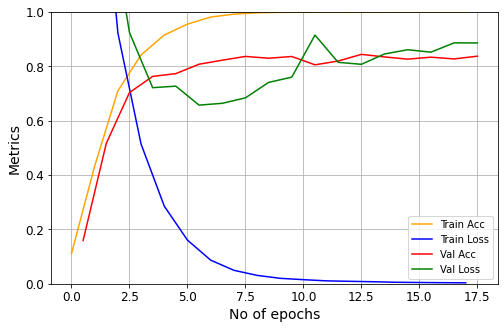

In [24]:
# parameteres for the baseline model
hiddensizes = [16, 32, 16]
actfn='relu'
optimizer = keras.optimizers.SGD
learningrate = 0.01
n_epochs = 20
with tf.device('/device:CPU:0'):
    # create the model
    model_baseline_cnn = build_baseline_cnn(hiddensizes, actfn, optimizer, learningrate)
    
    # fit the model
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True) 
    history = model_baseline_cnn.fit(X_train, y_train, epochs=n_epochs, callbacks = [early_stopping], validation_data=(X_val, y_val), verbose=1)
    
    # plot 
    plot_history(history)

In [25]:
# Display best accuracy on validation set
max_val_acc = np.max(history.history['val_accuracy'])
print(f'Best validation accuracy = {max_val_acc:.3f}')   # NB: .3f displays 3 decimal places

# Evaluate on testset
testres = model_baseline_cnn.evaluate(X_test, y_test, verbose=0)
print(f'Accuracy on test set = {testres[1]:.3f}')

Best validation accuracy = 0.844


2022-08-19 19:44:03.685350: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Accuracy on test set = 0.850


We are getting a test accuracy of 85.0%. But we need to get accuracy more than 96%. Also the loss starts increasing after 5th epoch.

In [26]:
# Build CNN
def build_cnn(hiddensizes, actfn, optimizer, learningrate):
    """"
    Parameters 
        hiddensizes : list of units for layers which are the dimensionality of the output space of the partiuclar layer
        actfn : Activation fuctions like relu or softmax to be used by the layer
        optimizer : Optimizers like Adam or SGD
        learninrate : learning rate
    Return
        return a sequential model
    """
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(filters=hiddensizes[0], kernel_size=3, strides=1, activation=actfn, padding="same", 
                                input_shape=[28, 28, 1]))    # input layer goes into this 2D convolution
    model.add(keras.layers.MaxPooling2D(pool_size=2))          # Pool (downsize)

    for n in hiddensizes[1:]:
        model.add(keras.layers.Conv2D(filters=n, kernel_size=3, strides=1, padding="same", activation=actfn))  # 2nd Conv
        model.add(keras.layers.Dropout(0.25)) #dropout layer
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.MaxPooling2D(pool_size=2))          # Pool (downsize)


    model.add(keras.layers.Flatten()) # unravel into a 1D vector
    model.add(keras.layers.Dense(100, activation = "relu"))  
    model.add(keras.layers.Dense(25, activation = "softmax"))  # always have 10 classes
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])   
    return model

I have added dropout layer from the second convolution layers. As my models have so many parameters, i need to drop some neurons inorder to prevent overfitiing. This is achieved by using dropout, which drops 25% of neurons from the layer before. I am only using droput from the 2nd layers onwards because, the conv layers might learn small but important features like lines and curves. So in my epxeriments, the model has always performed better if i use dropout only after 2 conv layers. I think its because if use dropout after the first layer, its loosing valubale information that will be used to learn more complex features in the subsequent layers.

I also added batch normalization layer after dropout layer. It should make the model more stable and make the network converege faster. What it means is that with cnn and other deep neural networks, when a particular layers parameters updates based on previous layer, the parameters of the previous layer will also change which slows down the training requiring lower lr.

Maxpooling layer helps us highlight the best features from the last layer by taking the max of neibghourhood values.

The ordering of conv2D->Dropout->Batch Norm is purely a personal choice from what has worked for me in the past. There is often debate on whether batch norm should be after conv layer followed by dropout or the other way around. There are aslo papers saying that activation should be after batch normalization and not  before it. Diving deeper into this ordering i believe is beyond the scope of this assignment.

I also added a dense layer of 100 units before the last classification softmax layer. It is because the conv layers learn complex features in our case cause they are classifying hand symbols and there are very similar ones belonging to different classes. So if i use the less complex softmax layer just after conv layers, i will loose a lot of information. So to capture that complex features i am using dense layer after unraveling with flatten

In [27]:
def do_all(hiddensizes, actfn, optimizer, learningrate, n_epochs):
    """"
    Parameters 
        hiddensizes : list of units for layers which are the dimensionality of the output space of the partiuclar layer
        actfn : Activation fuctions like relu or softmax to be used by the layer
        optimizer : Optimizers like Adam or SGD
        learninrate : learning rate
        n_epochs : no of epochs
    Return
        maximmun validation acc, test accurcay, model history, sequential model
    """
    # create the model
    model_cnn = build_cnn(hiddensizes, actfn, optimizer, learningrate)
    
    # fit the model
    learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)
    history = model_cnn.fit(X_train, y_train, epochs=n_epochs, callbacks = [ learning_rate_reduction], validation_data=(X_val, y_val), verbose=1)
    
    # get max val accuracy
    max_val_acc = np.max(history.history['val_accuracy'])
    
    # get test accuracy
    testres = model_cnn.evaluate(X_test, y_test, verbose=0)
    
    return max_val_acc, testres[1], history, model_cnn

Now lets do hyperparamter tuning for the CNN. There is no valid reason for choosing powers of 2 as the number of units. I start with 32 and go up to 256 because i bellieve the model needs to be complex enough to learn from this data. And the choice of learning rate and optimizers are the same reasons as i described above.

While tuning i am using learning rate as the callback as i think i could get better results than specfying just 3 or 4 learning rates. "This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced" (Keras doc)

Epoch 1/20
858/858 [==============================] - 8s 9ms/step - loss: 0.3986 - accuracy: 0.8853 - val_loss: 0.3576 - val_accuracy: 0.8985 - lr: 0.0010
Epoch 2/20
858/858 [==============================] - 8s 10ms/step - loss: 0.0238 - accuracy: 0.9934 - val_loss: 0.5258 - val_accuracy: 0.8689 - lr: 0.0010
Epoch 3/20
858/858 [==============================] - 8s 9ms/step - loss: 0.0232 - accuracy: 0.9931 - val_loss: 0.3289 - val_accuracy: 0.9175 - lr: 0.0010
Epoch 4/20
858/858 [==============================] - 8s 9ms/step - loss: 0.0058 - accuracy: 0.9984 - val_loss: 0.8942 - val_accuracy: 0.8146 - lr: 0.0010
Epoch 5/20
858/858 [==============================] - ETA: 0s - loss: 0.0314 - accuracy: 0.9905
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
858/858 [==============================] - 8s 9ms/step - loss: 0.0314 - accuracy: 0.9905 - val_loss: 0.4026 - val_accuracy: 0.9052 - lr: 0.0010
Epoch 6/20
858/858 [==============================] - 7s 9ms/st

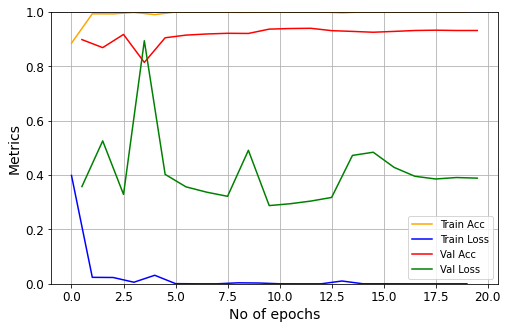

[0.940044641494751, 0.9339096546173096, [32, 64], 0, 'Adam']
Epoch 1/20
858/858 [==============================] - 8s 9ms/step - loss: 0.9711 - accuracy: 0.7260 - val_loss: 0.5181 - val_accuracy: 0.8494 - lr: 0.0100
Epoch 2/20
858/858 [==============================] - 7s 9ms/step - loss: 0.0877 - accuracy: 0.9883 - val_loss: 0.3304 - val_accuracy: 0.9085 - lr: 0.0100
Epoch 3/20
858/858 [==============================] - 7s 9ms/step - loss: 0.0307 - accuracy: 0.9984 - val_loss: 0.3422 - val_accuracy: 0.8977 - lr: 0.0100
Epoch 4/20
858/858 [==============================] - 7s 9ms/step - loss: 0.0168 - accuracy: 0.9996 - val_loss: 0.2999 - val_accuracy: 0.9127 - lr: 0.0100
Epoch 5/20
858/858 [==============================] - 7s 9ms/step - loss: 0.0113 - accuracy: 0.9998 - val_loss: 0.2926 - val_accuracy: 0.9230 - lr: 0.0100
Epoch 6/20
858/858 [==============================] - 7s 9ms/step - loss: 0.0083 - accuracy: 0.9999 - val_loss: 0.2816 - val_accuracy: 0.9200 - lr: 0.0100
Epoch 7/2

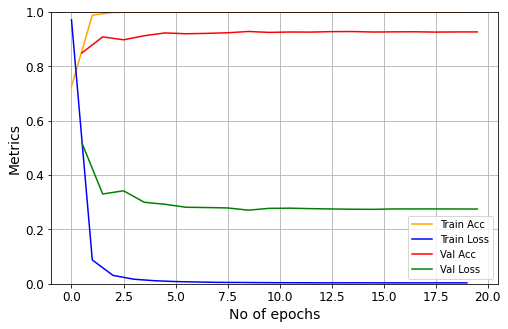

[0.9283323884010315, 0.9258226156234741, [32, 64], 0, 'SGD']
Epoch 1/20
858/858 [==============================] - 13s 14ms/step - loss: 0.4512 - accuracy: 0.8641 - val_loss: 0.2592 - val_accuracy: 0.9155 - lr: 0.0010
Epoch 2/20
858/858 [==============================] - 12s 14ms/step - loss: 0.0301 - accuracy: 0.9913 - val_loss: 0.1636 - val_accuracy: 0.9400 - lr: 0.0010
Epoch 3/20
858/858 [==============================] - 11s 13ms/step - loss: 0.0215 - accuracy: 0.9932 - val_loss: 0.2367 - val_accuracy: 0.9361 - lr: 0.0010
Epoch 4/20
855/858 [============================>.] - ETA: 0s - loss: 0.0348 - accuracy: 0.9885
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
858/858 [==============================] - 12s 14ms/step - loss: 0.0348 - accuracy: 0.9886 - val_loss: 0.9579 - val_accuracy: 0.8274 - lr: 0.0010
Epoch 5/20
858/858 [==============================] - 12s 14ms/step - loss: 0.0033 - accuracy: 0.9990 - val_loss: 0.1506 - val_accuracy: 0.9640 - lr: 

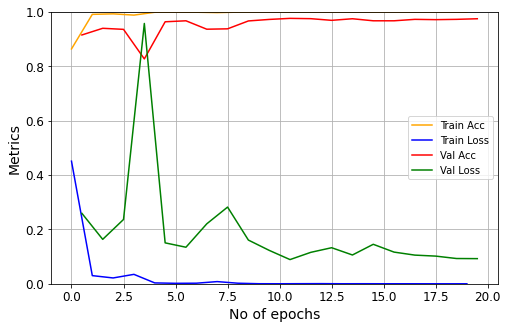

[0.9765755534172058, 0.9721137881278992, [32, 64, 128], 0, 'Adam']
Epoch 1/20
858/858 [==============================] - 14s 16ms/step - loss: 0.8874 - accuracy: 0.7258 - val_loss: 0.4036 - val_accuracy: 0.8907 - lr: 0.0100
Epoch 2/20
858/858 [==============================] - 13s 15ms/step - loss: 0.0803 - accuracy: 0.9809 - val_loss: 0.3304 - val_accuracy: 0.8960 - lr: 0.0100
Epoch 3/20
858/858 [==============================] - 13s 15ms/step - loss: 0.0317 - accuracy: 0.9940 - val_loss: 0.2427 - val_accuracy: 0.9233 - lr: 0.0100
Epoch 4/20
858/858 [==============================] - 13s 16ms/step - loss: 0.0178 - accuracy: 0.9969 - val_loss: 0.2011 - val_accuracy: 0.9350 - lr: 0.0100
Epoch 5/20
858/858 [==============================] - 13s 15ms/step - loss: 0.0122 - accuracy: 0.9980 - val_loss: 0.1486 - val_accuracy: 0.9481 - lr: 0.0100
Epoch 6/20
858/858 [==============================] - 13s 15ms/step - loss: 0.0077 - accuracy: 0.9994 - val_loss: 0.1421 - val_accuracy: 0.9543 - lr

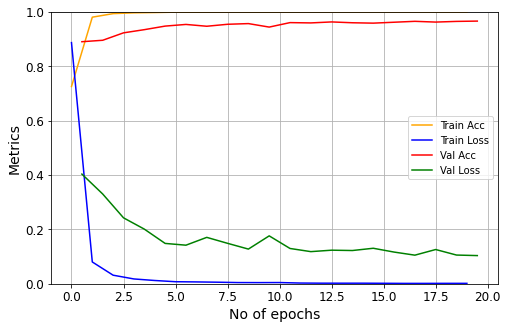

[0.9665365219116211, 0.9707194566726685, [32, 64, 128], 0, 'SGD']
Epoch 1/20
858/858 [==============================] - 18s 21ms/step - loss: 0.6047 - accuracy: 0.8078 - val_loss: 0.2728 - val_accuracy: 0.8999 - lr: 0.0010
Epoch 2/20
858/858 [==============================] - 17s 20ms/step - loss: 0.0533 - accuracy: 0.9828 - val_loss: 0.2177 - val_accuracy: 0.9278 - lr: 0.0010
Epoch 3/20
858/858 [==============================] - 18s 21ms/step - loss: 0.0357 - accuracy: 0.9882 - val_loss: 0.3509 - val_accuracy: 0.8843 - lr: 0.0010
Epoch 4/20
858/858 [==============================] - 18s 21ms/step - loss: 0.0334 - accuracy: 0.9890 - val_loss: 0.1739 - val_accuracy: 0.9428 - lr: 0.0010
Epoch 5/20
858/858 [==============================] - 18s 21ms/step - loss: 0.0283 - accuracy: 0.9905 - val_loss: 0.2319 - val_accuracy: 0.9300 - lr: 0.0010
Epoch 6/20
858/858 [==============================] - ETA: 0s - loss: 0.0237 - accuracy: 0.9924
Epoch 6: ReduceLROnPlateau reducing learning rate to 

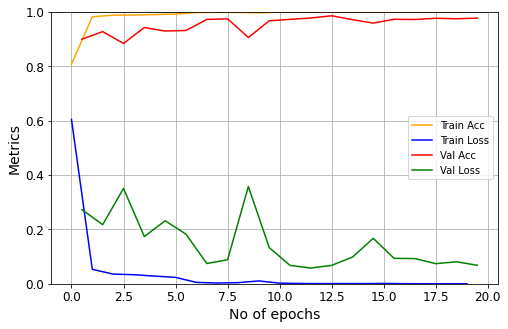

[0.9860568642616272, 0.9796430468559265, [32, 64, 128, 256], 0, 'Adam']
Epoch 1/20
858/858 [==============================] - 17s 20ms/step - loss: 1.1748 - accuracy: 0.6303 - val_loss: 0.6246 - val_accuracy: 0.7978 - lr: 0.0100
Epoch 2/20
858/858 [==============================] - 17s 19ms/step - loss: 0.1844 - accuracy: 0.9388 - val_loss: 0.4810 - val_accuracy: 0.8391 - lr: 0.0100
Epoch 3/20
858/858 [==============================] - 17s 20ms/step - loss: 0.0710 - accuracy: 0.9793 - val_loss: 0.2086 - val_accuracy: 0.9308 - lr: 0.0100
Epoch 4/20
858/858 [==============================] - 17s 20ms/step - loss: 0.0476 - accuracy: 0.9856 - val_loss: 0.1790 - val_accuracy: 0.9439 - lr: 0.0100
Epoch 5/20
858/858 [==============================] - 17s 20ms/step - loss: 0.0310 - accuracy: 0.9911 - val_loss: 0.1177 - val_accuracy: 0.9635 - lr: 0.0100
Epoch 6/20
858/858 [==============================] - 18s 21ms/step - loss: 0.0187 - accuracy: 0.9953 - val_loss: 0.1002 - val_accuracy: 0.9671

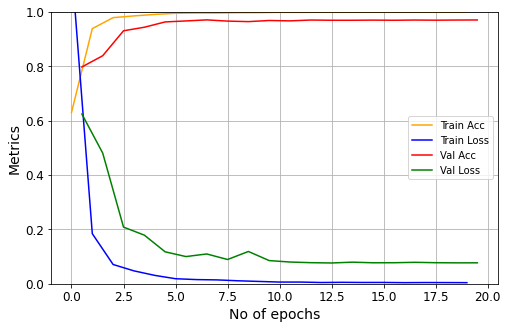

[0.9709983468055725, 0.9746235609054565, [32, 64, 128, 256], 0, 'SGD']
Epoch 1/20
858/858 [==============================] - 62s 72ms/step - loss: 1.0434 - accuracy: 0.6667 - val_loss: 0.8323 - val_accuracy: 0.7342 - lr: 0.0010
Epoch 2/20
858/858 [==============================] - 61s 72ms/step - loss: 0.1826 - accuracy: 0.9384 - val_loss: 0.2103 - val_accuracy: 0.9311 - lr: 0.0010
Epoch 3/20
858/858 [==============================] - 62s 73ms/step - loss: 0.0937 - accuracy: 0.9699 - val_loss: 0.6683 - val_accuracy: 0.7744 - lr: 0.0010
Epoch 4/20
858/858 [==============================] - ETA: 0s - loss: 0.0595 - accuracy: 0.9802
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
858/858 [==============================] - 63s 74ms/step - loss: 0.0595 - accuracy: 0.9802 - val_loss: 0.7942 - val_accuracy: 0.7546 - lr: 0.0010
Epoch 5/20
858/858 [==============================] - 63s 73ms/step - loss: 0.0280 - accuracy: 0.9907 - val_loss: 0.1111 - val_accuracy: 0.9

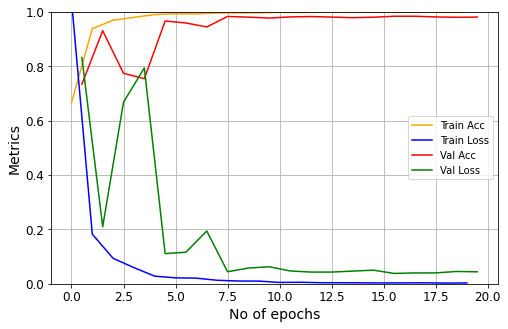

[0.9843837022781372, 0.9804796576499939, [256, 128, 64, 32], 0, 'Adam']
Epoch 1/20
858/858 [==============================] - 63s 73ms/step - loss: 1.8463 - accuracy: 0.4324 - val_loss: 2.0262 - val_accuracy: 0.3394 - lr: 0.0100
Epoch 2/20
858/858 [==============================] - 64s 74ms/step - loss: 0.5560 - accuracy: 0.8159 - val_loss: 1.3711 - val_accuracy: 0.5310 - lr: 0.0100
Epoch 3/20
858/858 [==============================] - 60s 70ms/step - loss: 0.2695 - accuracy: 0.9114 - val_loss: 0.5166 - val_accuracy: 0.8717 - lr: 0.0100
Epoch 4/20
858/858 [==============================] - 62s 72ms/step - loss: 0.1519 - accuracy: 0.9540 - val_loss: 0.3121 - val_accuracy: 0.9253 - lr: 0.0100
Epoch 5/20
858/858 [==============================] - 61s 72ms/step - loss: 0.1071 - accuracy: 0.9669 - val_loss: 0.3434 - val_accuracy: 0.8879 - lr: 0.0100
Epoch 6/20
858/858 [==============================] - 59s 69ms/step - loss: 0.0747 - accuracy: 0.9779 - val_loss: 0.1976 - val_accuracy: 0.9504

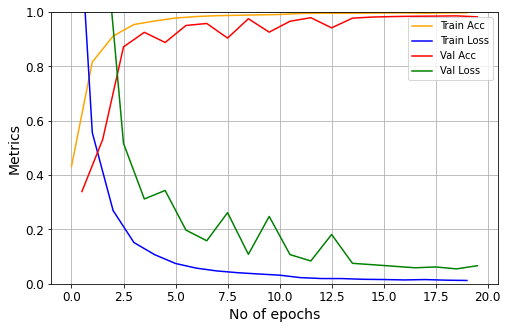

[0.9857780337333679, 0.9827105402946472, [256, 128, 64, 32], 0, 'SGD']


In [28]:
hiddensizes_list = [[ 32, 64], [ 32, 64, 128], [ 32, 64, 128, 256], [ 256, 128, 64, 32] ]
optimizer_list = ['Adam', 'SGD'] 
actfn = "relu"
n_epochs=20
learningrate = 0
values=[]
with tf.device('/device:CPU:0'):
    # iterate through all possible combinations of hypermaters
    for hiddensizes in hiddensizes_list:
            for optimizer in optimizer_list:
                # train the model
                val_acc, test_acc, history, model_cnn = do_all(hiddensizes, actfn, optimizer, learningrate, n_epochs)
                # plot the history
                plot_history(history)
                print([val_acc, test_acc, hiddensizes, learningrate, optimizer])
                # append the values to the list for displaying it as a table
                values.append([val_acc, test_acc, hiddensizes, optimizer])
            

In [29]:
# display results
df = pd.DataFrame(values, columns = ['Val_acc', 'Test_acc', 'hiddensizes', 'optimizer'])
df = df.sort_values(by=['Val_acc'], ascending=False)
df

,Val_acc,Test_acc,hiddensizes,optimizer
4,0.986057,0.979643,"[32, 64, 128, 256]",Adam
7,0.985778,0.982711,"[256, 128, 64, 32]",SGD
6,0.984384,0.980480,"[256, 128, 64, 32]",Adam
2,0.976576,0.972114,"[32, 64, 128]",Adam
5,0.970998,0.974624,"[32, 64, 128, 256]",SGD
3,0.966537,0.970719,"[32, 64, 128]",SGD
0,0.940045,0.933910,"[32, 64]",Adam
1,0.928332,0.925823,"[32, 64]",SGD


![](output2.png)

This the training curves for the 1st best model in terms of val accuracy with Unit sizes as [32, 64, 128, 256] and optimizer as 'Adam'

![](outpu1t.png)

This the training curves for the 5th best model in terms of val accuracy with Unit sizes as [32, 64, 128, 256] and optimizer as 'SGD'. But the training curves for this model looks much more better than the best model with max val accuracy. There is little to no sign of over fitting and the no sudden variations.


For these reasons i will go with the hyperparamter settings for the above model

**********

Now lets train the model on the best hyper parameters we found above.

Epoch 1/20
858/858 [==============================] - 15s 17ms/step - loss: 1.0048 - accuracy: 0.6839 - val_loss: 0.7496 - val_accuracy: 0.7646 - lr: 0.0100
Epoch 2/20
858/858 [==============================] - 14s 17ms/step - loss: 0.1367 - accuracy: 0.9594 - val_loss: 0.5030 - val_accuracy: 0.8383 - lr: 0.0100
Epoch 3/20
858/858 [==============================] - 14s 16ms/step - loss: 0.0597 - accuracy: 0.9829 - val_loss: 0.2807 - val_accuracy: 0.9113 - lr: 0.0100
Epoch 4/20
858/858 [==============================] - 13s 16ms/step - loss: 0.0360 - accuracy: 0.9901 - val_loss: 0.2042 - val_accuracy: 0.9453 - lr: 0.0100
Epoch 5/20
858/858 [==============================] - 13s 16ms/step - loss: 0.0211 - accuracy: 0.9946 - val_loss: 0.1148 - val_accuracy: 0.9685 - lr: 0.0100
Epoch 6/20
858/858 [==============================] - 15s 17ms/step - loss: 0.0180 - accuracy: 0.9956 - val_loss: 0.1750 - val_accuracy: 0.9512 - lr: 0.0100
Epoch 7/20
858/858 [==============================] - ETA:

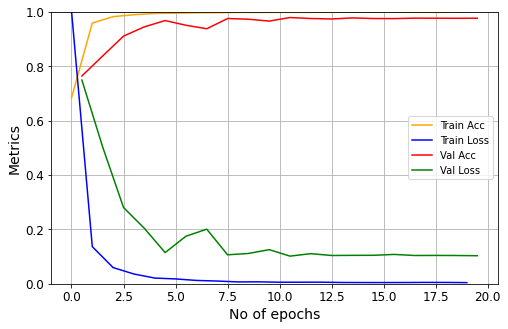

In [30]:
# hyper parameters
hiddensizes = [32, 64, 128, 256]
actfn='relu'
optimizer = 'SGD'
learningrate = 0
n_epochs = 20

with tf.device('/device:CPU:0'):
    # fit and plot the model
    val_acc, test_acc, history, model_cnn = do_all(hiddensizes, actfn, optimizer, learningrate, n_epochs)
    model_cnn.summary()
    plot_history(history)

In [31]:
# Display best accuracy on validation set
max_val_acc = np.max(history.history['val_accuracy'])
print(f'Best validation accuracy = {max_val_acc:.3f}')   # NB: .3f displays 3 decimal places

# Evaluate on testset
testres = model_cnn.evaluate(X_test, y_test, verbose=0)
print(f'Accuracy on test set = {testres[1]:.3f}')

Best validation accuracy = 0.980


2022-08-19 21:02:56.448630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Accuracy on test set = 0.977


We can see that the test accuracy meets the criteria of above 96%

**********

Lets calculate individual accuracy for each class.

In [32]:
from sklearn.metrics import confusion_matrix
# predcit on the test set
y_proba = model_cnn.predict(X_test)
y_pred=np.argmax(y_proba,axis=1)
classes = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y']


# calculate accuracies using confusion matrix
matrix = confusion_matrix(y_test, y_pred)
individual_acc = matrix.diagonal()/matrix.sum(axis=1)

for i in range(24):
    print(classes[i]," : ","{:.2f}".format(individual_acc[i]*100),"%")

 33/113 [=======>......................] - ETA: 0s

2022-08-19 21:03:00.078742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


113/113 [==============================] - 1s 6ms/step
a  :  100.00 %
b  :  100.00 %
c  :  100.00 %
d  :  100.00 %
e  :  100.00 %
f  :  100.00 %
g  :  88.51 %
h  :  100.00 %
i  :  100.00 %
k  :  98.80 %
l  :  100.00 %
m  :  100.00 %
n  :  100.00 %
o  :  100.00 %
p  :  100.00 %
q  :  100.00 %
r  :  98.61 %
s  :  100.00 %
t  :  75.81 %
u  :  100.00 %
v  :  95.95 %
w  :  100.00 %
x  :  98.51 %
y  :  87.35 %


From this we can see the letters with least accuarcy are 't', 'y' and 'g' . They have accuracy below 90 with 't' having the lowest. Now lets see what are these letters being wrongly predcited as.

<AxesSubplot:>

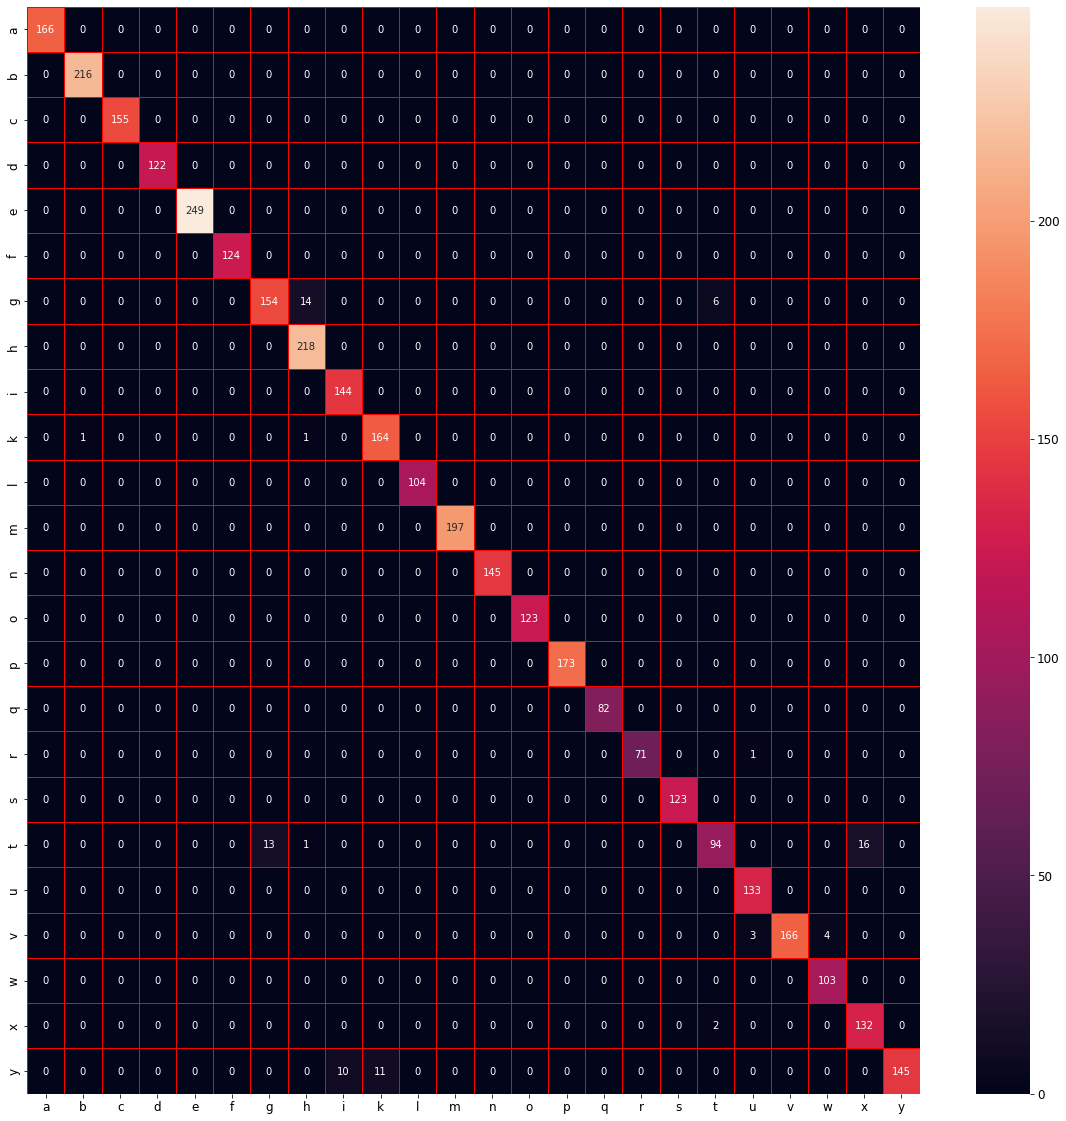

In [41]:
import seaborn as sns
best_model_confusion_matrix_df = pd.DataFrame(matrix ,index = classes , columns = classes)
plt.figure(figsize = (20,20))
sns.heatmap(best_model_confusion_matrix_df,cmap= "rocket", linecolor = 'red' ,linewidth = 1 , annot = True, fmt='')

By looking at the above confusion matrix i can infer that 't' was misclassified 16 times as 'x'
In the case of 'g' 14 times it was misclassified as 'h' and 'y' was misclassified as 'k' the most.

## P Value Test

Let us use P value test to see how similar our models are.

In [68]:
from mlxtend.evaluate import permutation_test   # pip install mlxtend
from sklearn.metrics import  accuracy_score

Epoch 1/20
858/858 [==============================] - 15s 17ms/step - loss: 0.5646 - accuracy: 0.8207 - val_loss: 0.3972 - val_accuracy: 0.8748 - lr: 0.0010
Epoch 2/20
858/858 [==============================] - 15s 17ms/step - loss: 0.0522 - accuracy: 0.9837 - val_loss: 0.3525 - val_accuracy: 0.8935 - lr: 0.0010
Epoch 3/20
858/858 [==============================] - 14s 17ms/step - loss: 0.0419 - accuracy: 0.9858 - val_loss: 0.1508 - val_accuracy: 0.9587 - lr: 0.0010
Epoch 4/20
858/858 [==============================] - 15s 17ms/step - loss: 0.0241 - accuracy: 0.9921 - val_loss: 0.2994 - val_accuracy: 0.9069 - lr: 0.0010
Epoch 5/20
858/858 [==============================] - ETA: 0s - loss: 0.0228 - accuracy: 0.9932
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
858/858 [==============================] - 14s 16ms/step - loss: 0.0228 - accuracy: 0.9932 - val_loss: 0.8721 - val_accuracy: 0.7981 - lr: 0.0010
Epoch 6/20
858/858 [==============================] - 

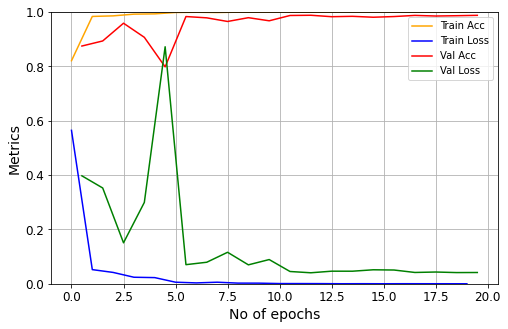

In [82]:
# hyper parameters
hiddensizes = [32, 64, 128, 256]
actfn='relu'
optimizer = 'Adam'
n_epochs = 20

with tf.device('/device:CPU:0'):
    # fit and plot the model
    val_acc, test_acc, history, second_model_cnn = do_all(hiddensizes, actfn, optimizer, learningrate, n_epochs)
    plot_history(history)

Now let us get predictions from both models 

In [75]:
y_val_pred = list()
y_val_pred+=[np.argmax(model_cnn.predict(X_test), axis=1)]
y_val_pred+=[np.argmax(second_model_cnn.predict(X_test), axis=1)]


113/113 [==============================] - 1s 6ms/step


In [77]:
# Let us calculate the p score now
P_score = permutation_test(y_val_pred[0], y_val_pred[1], paired=True,  
            func=lambda x, y: np.abs(accuracy_score(y_test,x) - accuracy_score(y_test,x)),
            method="approximate", seed=0, num_rounds=1000)

print(f'P value comparing methods: {P_score:.3f} ')

P value comparing methods: 1.000 


So i conclude both models are very similar by looking at p score